In [3]:
import sys
sys.path.append("/home/sara/lib")
# sys.path

In [4]:
#!/usr/bin/python
import csv
import gc
import numpy as np
import pylab as pl
import pandas as pd
from time import time
import libopf_py

from sklearn.utils import shuffle
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# adaptações ao OPF.
def opf(train_labels1, train_feat1, test_labels1, test_feat1):
        
    # OPF only supports 32 bits labels at the moment
    label_train_32 = train_labels1.astype(np.int32)
    label_test_32 = test_labels1.astype(np.int32)

    O = libopf_py.OPF()

    O.fit(train_feat1, label_train_32)

    predicted = O.predict(test_feat1)
    name = "OPF"
    acc = accuracy_score(label_test_32, predicted)
    
    return acc 

In [6]:
def read_csv():
    file = pd.read_csv("csv_dataset/dataframe_7emocoes com numeros.csv", sep=';')
    return file

In [7]:
def read_dataset():
    df = read_csv()
    df = df.drop(columns='Unnamed: 0')
    df = shuffle(df)
    X = df.iloc[0:1925,0:136]
    X = X.to_numpy()
    X = X.astype('float64')
    y = df.iloc[0:,136]
    y = y.to_numpy()
    y = y.astype('float64')
    
    #return X, y
    benchmark(X, y, len(y))

In [12]:
def benchmark(data, target, n_samples):
    #list_n_samples = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    list_n_samples = np.arange(0.05, 1.0, 0.05)
    opf_results = np.zeros((len(list_n_samples), 5))
    svm_results = np.zeros((len(list_n_samples), 5))
    knn_results = np.zeros((len(list_n_samples), 5))
    bayes_results = np.zeros((len(list_n_samples), 5))
    linear_results = np.zeros((len(list_n_samples), 5))
    sgd_results = np.zeros((len(list_n_samples), 5))
    tree_results = np.zeros((len(list_n_samples), 5))

    for i, size in enumerate(list_n_samples):
        n_split = int(size * n_samples)
        rand = np.random.permutation(n_samples)
        random_data = data[rand]
        random_label = target[rand]
        data_train, data_test = random_data[:n_split], random_data[n_split:]
        label_train, label_test = random_label[:n_split], random_label[n_split:]
        print("tamanho data test: ", len(data_test))
        print("tamanho label test: ", len(label_test))

        def _opf():
            label_train_32 = label_train.astype(np.int32)
            label_test_32 = label_test.astype(np.int32)
            O = libopf_py.OPF()
            t = time()
            O.fit(data_train, label_train_32)

            opf_results[i, 3] = time() - t
            t = time()
            print("----------OPF------------")
            print("Tempo: ", opf_results[i, 3])
            predicted = O.predict(data_test)
            print("label test: ", label_test_32)
            print("predicted: ", predicted)
            opf_results[i, 0] = opf(label_train_32, data_train, label_test_32, data_test)
            print("accuracy: ", opf_results[i, 0])
            opf_results[i, 4] = precision_score(label_test_32, predicted, average='weighted')
            opf_results[i, 1] = recall_score(label_test_32, predicted, average='weighted')
            opf_results[i, 2] = f1_score(label_test_32, predicted, average='weighted')
            if i == 0:
                print("Classification report:\n%s\n" % (classification_report(label_test, predicted)))
                print("Confusion matrix:\n%s" % confusion_matrix(label_test, predicted))
            gc.collect()

        def _svm():
            clf = svm.SVC(kernel='linear', C=1000, gamma='auto')
            t = time()
            print("-----------SVM-----------")
            
            clf.fit(data_train, label_train)
            svm_results[i, 3] = time() - t
            print("Tempo: ", svm_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            svm_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", svm_results[i, 0])
            svm_results[i, 4] = precision_score(label_test, predicted, average='micro')
            svm_results[i, 1] = recall_score(label_test, predicted, average='micro')
            svm_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()
            
        def _knn():
            clf = KNeighborsClassifier(n_neighbors=3)
            t = time()
            print("-----------KNN-----------")
            
            clf.fit(data_train, label_train)
            knn_results[i, 3] = time() - t
            print("Tempo: ", knn_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            knn_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", knn_results[i, 0])
            knn_results[i, 4] = precision_score(label_test, predicted, average='micro')
            knn_results[i, 1] = recall_score(label_test, predicted, average='micro')
            knn_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()

        def _bayes():
            clf = GaussianNB()
            t = time()
            print("-----------BAYES-----------")
            
            clf.fit(data_train, label_train)
            bayes_results[i, 3] = time() - t
            print("Tempo: ", bayes_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            bayes_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", bayes_results[i, 0])
            bayes_results[i, 4] = precision_score(label_test, predicted, average='micro')
            bayes_results[i, 1] = recall_score(label_test, predicted, average='micro')
            bayes_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()

        def _linear():
            clf = LogisticRegression(C=1, penalty='l2', solver='liblinear')
            t = time()
            print("-----------LINEAR-----------")
            
            clf.fit(data_train, label_train)
            linear_results[i, 3] = time() - t
            print("Tempo: ", linear_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            linear_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", linear_results[i, 0])
            linear_results[i, 4] = precision_score(label_test, predicted, average='micro')
            linear_results[i, 1] = recall_score(label_test, predicted, average='micro')
            linear_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()

        def _sgd():
            clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000, tol=1e-3)
            t = time()
            print("-----------SGD-----------")
            
            clf.fit(data_train, label_train)
            sgd_results[i, 3] = time() - t
            print("Tempo: ", sgd_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            sgd_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", sgd_results[i, 0])
            sgd_results[i, 4] = precision_score(label_test, predicted, average='micro')
            sgd_results[i, 1] = recall_score(label_test, predicted, average='micro')
            sgd_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()

        def _tree():
            clf = tree.DecisionTreeClassifier()
            t = time()
            print("-----------TREE-----------")
            
            clf.fit(data_train, label_train)
            tree_results[i, 3] = time() - t
            print("Tempo: ", tree_results[i, 3])
            predicted = clf.predict(data_test)
            print("label test: ", label_test)
            print("predicted: ", predicted)
            tree_results[i, 0] = accuracy_score(label_test, predicted)
            print("accuracy: ", tree_results[i, 0])
            tree_results[i, 4] = precision_score(label_test, predicted, average='micro')
            tree_results[i, 1] = recall_score(label_test, predicted, average='micro')
            tree_results[i, 2] = f1_score(label_test, predicted, average='micro')
            gc.collect()

        _opf()
        _svm()
        _knn()
        _bayes()
        _linear()
        _sgd()
        _tree()

    pl.figure()
    pl.plot(list_n_samples, opf_results[:, 0], label="OPF")
    pl.plot(list_n_samples, svm_results[:, 0], label="SVM")
    pl.plot(list_n_samples, knn_results[:, 0], label="KNN")
    pl.plot(list_n_samples, bayes_results[:, 0], label="Naive Bayes")
    pl.plot(list_n_samples, linear_results[:, 0], label="Logistic Regression")
    pl.plot(list_n_samples, sgd_results[:, 0], label="SGD")
    pl.plot(list_n_samples, tree_results[:, 0], label="Decision Trees")
    pl.legend(loc='lower right', prop=dict(size=8))
    pl.xlabel("Training set size")
    pl.ylabel("acc score")
    pl.show()
    
    pl.figure()
    pl.scatter(opf_results[:, 4], opf_results[:, 1], label="OPF")
    pl.plot(opf_results[:, 4], opf_results[:, 1], '-o')
    pl.scatter(svm_results[:, 4], svm_results[:, 1], label="SVM")
    pl.plot(svm_results[:, 4], svm_results[:, 1], '-o')
    pl.scatter(knn_results[:, 4], knn_results[:, 1], label="KNN")
    pl.plot(knn_results[:, 4], knn_results[:, 1], '-o')
    pl.scatter(bayes_results[:, 4], bayes_results[:, 1], label="Naive Bayes")
    pl.plot(bayes_results[:, 4], bayes_results[:, 1], '-o')
    pl.scatter(linear_results[:, 4], linear_results[:, 1], label="Logistic Regression")
    pl.plot(linear_results[:, 4], linear_results[:, 1], '-o')
    pl.scatter(sgd_results[:, 4], sgd_results[:, 1], label="SGD")
    pl.plot(sgd_results[:, 4], sgd_results[:, 1], '-o')
    pl.scatter(tree_results[:, 4], tree_results[:, 1], label="Decision Trees")
    pl.plot(tree_results[:, 4], tree_results[:, 1], '-o')
    pl.legend(loc='lower right', prop=dict(size=8))
    pl.xlabel("Recall")
    pl.ylabel("Precision")
    pl.show()

tamanho data test:  1828
tamanho label test:  1828
----------OPF------------
Tempo:  0.002115011215209961
label test:  [ 9  9  2 ... 12  9  9]
predicted:  [13 22 13 ...  0  2 13]
accuracy:  0.3074398249452954
Classification report:
              precision    recall  f1-score   support

         0.0       0.27      0.38      0.32       228
         2.0       0.41      0.27      0.32       232
         9.0       0.32      0.27      0.29       300
        12.0       0.37      0.35      0.36       354
        13.0       0.21      0.27      0.23       254
        21.0       0.33      0.29      0.31       265
        22.0       0.30      0.32      0.31       195

   micro avg       0.31      0.31      0.31      1828
   macro avg       0.32      0.31      0.31      1828
weighted avg       0.32      0.31      0.31      1828


Confusion matrix:
[[ 86   6  18  29  58  21  10]
 [ 63  62  41  12  12  12  30]
 [ 24  37  81  42  43  24  49]
 [ 47  21  33 124  66  52  11]
 [ 33   7  30  53  68  33  3

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.013051271438598633
label test:  [ 9.  9.  2. ... 12.  9.  9.]
predicted:  [0. 0. 0. ... 0. 0. 0.]
accuracy:  0.12472647702407003
-----------TREE-----------
Tempo:  0.007269382476806641
label test:  [ 9.  9.  2. ... 12.  9.  9.]
predicted:  [ 2. 22. 21. ... 12. 21.  2.]
accuracy:  0.26531728665207877
tamanho data test:  1732
tamanho label test:  1732
----------OPF------------
Tempo:  0.006691455841064453
label test:  [ 9  9  0 ...  2 12  0]
predicted:  [13  9  0 ...  0  0 12]
accuracy:  0.39549653579676675
-----------SVM-----------
Tempo:  0.03937816619873047
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [ 9.  9.  0. ...  0. 12.  0.]
accuracy:  0.6079676674364896
-----------KNN-----------
Tempo:  0.0014605522155761719
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [ 9.  2.  0. ...  0.  9. 12.]
accuracy:  0.36143187066974597
-----------BAYES-----------
Tempo:  0.0029141902923583984
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [ 9.  9. 12. ... 13. 13. 

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.1492908000946045
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [ 9.  9.  0. ...  0. 12.  0.]
accuracy:  0.6587759815242494
-----------SGD-----------
Tempo:  0.02549266815185547
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [9. 9. 9. ... 9. 9. 9.]
accuracy:  0.16166281755196305
-----------TREE-----------
Tempo:  0.014331579208374023
label test:  [ 9.  9.  0. ...  2. 12.  0.]
predicted:  [12.  9.  0. ...  0.  9.  0.]
accuracy:  0.3504618937644342
tamanho data test:  1636
tamanho label test:  1636
----------OPF------------
Tempo:  0.01587390899658203
label test:  [21 21  9 ... 13 21 13]
predicted:  [13  0  9 ... 13  0 13]
accuracy:  0.41687041564792177
-----------SVM-----------
Tempo:  0.0785367488861084
label test:  [21. 21.  9. ... 13. 21. 13.]
predicted:  [21. 21.  9. ... 13. 21. 12.]
accuracy:  0.6528117359413202
-----------KNN-----------
Tempo:  0.001961946487426758
label test:  [21. 21.  9. ... 13. 21. 13.]
predicted:  [ 9.  0.  9. ... 13.  0. 13.]
accura

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.20420432090759277
label test:  [21. 21.  9. ... 13. 21. 13.]
predicted:  [21. 13.  9. ... 13. 21. 12.]
accuracy:  0.6699266503667481
-----------SGD-----------
Tempo:  0.07703590393066406
label test:  [21. 21.  9. ... 13. 21. 13.]
predicted:  [ 9. 13.  9. ...  9.  9. 13.]
accuracy:  0.21943765281173594
-----------TREE-----------
Tempo:  0.0242464542388916
label test:  [21. 21.  9. ... 13. 21. 13.]
predicted:  [21. 13.  2. ... 13. 21. 13.]
accuracy:  0.36797066014669927
tamanho data test:  1540
tamanho label test:  1540
----------OPF------------
Tempo:  0.026809215545654297
label test:  [21 21  0 ...  2 13 22]
predicted:  [13 13  0 ...  9 13 22]
accuracy:  0.45324675324675323
-----------SVM-----------
Tempo:  0.14751005172729492
label test:  [21. 21.  0. ...  2. 13. 22.]
predicted:  [21. 13.  0. ...  2. 13. 22.]
accuracy:  0.688961038961039
-----------KNN-----------
Tempo:  0.0030667781829833984
label test:  [21. 21.  0. ...  2. 13. 22.]
predicted:  [13.  9. 12. ...  9. 13. 22.

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.2879638671875
label test:  [21. 21.  0. ...  2. 13. 22.]
predicted:  [21. 13.  0. ...  2. 13. 22.]
accuracy:  0.7058441558441558
-----------SGD-----------
Tempo:  0.0885474681854248
label test:  [21. 21.  0. ...  2. 13. 22.]
predicted:  [9. 0. 0. ... 0. 0. 0.]
accuracy:  0.22402597402597402
-----------TREE-----------
Tempo:  0.03347921371459961
label test:  [21. 21.  0. ...  2. 13. 22.]
predicted:  [ 9. 12. 13. ...  9. 13. 22.]
accuracy:  0.39155844155844155
tamanho data test:  1443
tamanho label test:  1443
----------OPF------------
Tempo:  0.03468918800354004
label test:  [21  9 12 ... 12 13  2]
predicted:  [12 22 21 ... 21 13 12]
accuracy:  0.44213444213444214
-----------SVM-----------
Tempo:  0.32482218742370605
label test:  [21.  9. 12. ... 12. 13.  2.]
predicted:  [21.  9. 13. ... 21. 13. 13.]
accuracy:  0.7110187110187111
-----------KNN-----------
Tempo:  0.004146099090576172
label test:  [21.  9. 12. ... 12. 13.  2.]
predicted:  [ 0. 22.  9. ... 12. 13. 12.]
accuracy:

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.43318772315979004
label test:  [21.  9. 12. ... 12. 13.  2.]
predicted:  [21.  9. 13. ... 21. 13.  2.]
accuracy:  0.7248787248787248
-----------SGD-----------
Tempo:  0.061104536056518555
label test:  [21.  9. 12. ... 12. 13.  2.]
predicted:  [13. 13. 13. ... 21. 13. 13.]
accuracy:  0.20235620235620236
-----------TREE-----------
Tempo:  0.03571176528930664
label test:  [21.  9. 12. ... 12. 13.  2.]
predicted:  [12. 12. 21. ... 12. 13. 12.]
accuracy:  0.40817740817740816
tamanho data test:  1347
tamanho label test:  1347
----------OPF------------
Tempo:  0.049521684646606445
label test:  [12 22  0 ...  2  0  0]
predicted:  [12  0  0 ...  2 12  0]
accuracy:  0.48181143281366
-----------SVM-----------
Tempo:  0.23757600784301758
label test:  [12. 22.  0. ...  2.  0.  0.]
predicted:  [12. 22.  0. ...  2.  0.  0.]
accuracy:  0.7245731254639941
-----------KNN-----------
Tempo:  0.0028090476989746094
label test:  [12. 22.  0. ...  2.  0.  0.]
predicted:  [ 0.  0.  0. ...  2. 12.  0.

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.41785430908203125
label test:  [12. 22.  0. ...  2.  0.  0.]
predicted:  [12. 22.  0. ...  2.  9.  9.]
accuracy:  0.7275426874536006
-----------SGD-----------
Tempo:  0.0683894157409668
label test:  [12. 22.  0. ...  2.  0.  0.]
predicted:  [12. 22. 22. ...  2.  0. 22.]
accuracy:  0.348181143281366
-----------TREE-----------
Tempo:  0.048386573791503906
label test:  [12. 22.  0. ...  2.  0.  0.]
predicted:  [12. 22.  0. ...  2. 12. 12.]
accuracy:  0.40905716406829995
tamanho data test:  1251
tamanho label test:  1251
----------OPF------------
Tempo:  0.06785702705383301
label test:  [ 0 12 13 ... 13 13  9]
predicted:  [13 12  9 ... 12 12  9]
accuracy:  0.4580335731414868
-----------SVM-----------
Tempo:  0.2899465560913086
label test:  [ 0. 12. 13. ... 13. 13.  9.]
predicted:  [ 0. 21.  0. ...  9.  9. 12.]
accuracy:  0.7354116706634692
-----------KNN-----------
Tempo:  0.0040740966796875
label test:  [ 0. 12. 13. ... 13. 13.  9.]
predicted:  [ 0.  9.  9. ...  2. 12.  9.]
accu

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.9792466163635254
label test:  [ 0. 12. 13. ... 13. 13.  9.]
predicted:  [ 0. 21. 22. ... 13. 12.  9.]
accuracy:  0.7234212629896083
-----------SGD-----------
Tempo:  0.10221481323242188
label test:  [ 0. 12. 13. ... 13. 13.  9.]
predicted:  [13.  9. 13. ... 13. 13.  9.]
accuracy:  0.2741806554756195
-----------TREE-----------
Tempo:  0.0573427677154541
label test:  [ 0. 12. 13. ... 13. 13.  9.]
predicted:  [12. 12. 13. ... 22. 13.  9.]
accuracy:  0.40927258193445243
tamanho data test:  1155
tamanho label test:  1155
----------OPF------------
Tempo:  0.08209633827209473
label test:  [ 0 13  0 ... 22 21 21]
predicted:  [ 0 13  0 ... 21 21 12]
accuracy:  0.4831168831168831
-----------SVM-----------
Tempo:  0.8065018653869629
label test:  [ 0. 13.  0. ... 22. 21. 21.]
predicted:  [ 0. 13.  0. ... 13. 21. 21.]
accuracy:  0.7636363636363637
-----------KNN-----------
Tempo:  0.0030393600463867188
label test:  [ 0. 13.  0. ... 22. 21. 21.]
predicted:  [ 0.  0.  0. ... 22. 21.  0.]
ac

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.129544973373413
label test:  [ 0. 13.  0. ... 22. 21. 21.]
predicted:  [ 0. 13.  0. ... 22. 21. 21.]
accuracy:  0.7333333333333333
-----------SGD-----------
Tempo:  0.10413265228271484
label test:  [ 0. 13.  0. ... 22. 21. 21.]
predicted:  [ 0. 21. 21. ...  0. 21. 21.]
accuracy:  0.2502164502164502
-----------TREE-----------
Tempo:  0.0648949146270752
label test:  [ 0. 13.  0. ... 22. 21. 21.]
predicted:  [ 0. 13.  0. ... 13. 21.  0.]
accuracy:  0.42424242424242425
tamanho data test:  1059
tamanho label test:  1059
----------OPF------------
Tempo:  0.10708761215209961
label test:  [13 22 12 ...  2 12  9]
predicted:  [21  9 12 ...  9  0 12]
accuracy:  0.5080264400377715
-----------SVM-----------
Tempo:  0.5886080265045166
label test:  [13. 22. 12. ...  2. 12.  9.]
predicted:  [13. 22.  0. ...  2. 12.  9.]
accuracy:  0.7582625118035883
-----------KNN-----------
Tempo:  0.005990743637084961
label test:  [13. 22. 12. ...  2. 12.  9.]
predicted:  [21.  9. 12. ...  0.  0. 12.]
accu

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.019866704940796
label test:  [13. 22. 12. ...  2. 12.  9.]
predicted:  [13. 22.  0. ...  2. 12.  9.]
accuracy:  0.7308781869688386
-----------SGD-----------
Tempo:  0.12172889709472656
label test:  [13. 22. 12. ...  2. 12.  9.]
predicted:  [12. 12. 12. ... 12. 12. 12.]
accuracy:  0.2898961284230406
-----------TREE-----------
Tempo:  0.06709647178649902
label test:  [13. 22. 12. ...  2. 12.  9.]
predicted:  [13.  9. 12. ... 12.  0.  0.]
accuracy:  0.4428706326723324
tamanho data test:  962
tamanho label test:  962
----------OPF------------
Tempo:  0.13164567947387695
label test:  [22 21 13 13  2  9 21 21  0  9 13 12  9 21 12 12 13  2  0  9 22 21 21 13
  9  9  0 12 22 13  9  0 22  0 12 12 12 22 21 21  0 12 21  0  0 13 22  0
 13  2 12 12 21 21 21  9  9 22  2  2  9 13 21 13  0  2 22  0 13 12 13 22
  0 13  2  9 21 12  9 21 12  9  2  9  2  0  2 12  9  9  9 12  2 21  2 21
  9 12 21 21  9  9 22  9  0 22  2 21 22 13 13 22  0 13  0  2  0 12  9 21
  2 12  0 12  2  0 13 21  2 13 21 21 21

label test:  [22. 21. 13. 13.  2.  9. 21. 21.  0.  9. 13. 12.  9. 21. 12. 12. 13.  2.
  0.  9. 22. 21. 21. 13.  9.  9.  0. 12. 22. 13.  9.  0. 22.  0. 12. 12.
 12. 22. 21. 21.  0. 12. 21.  0.  0. 13. 22.  0. 13.  2. 12. 12. 21. 21.
 21.  9.  9. 22.  2.  2.  9. 13. 21. 13.  0.  2. 22.  0. 13. 12. 13. 22.
  0. 13.  2.  9. 21. 12.  9. 21. 12.  9.  2.  9.  2.  0.  2. 12.  9.  9.
  9. 12.  2. 21.  2. 21.  9. 12. 21. 21.  9.  9. 22.  9.  0. 22.  2. 21.
 22. 13. 13. 22.  0. 13.  0.  2.  0. 12.  9. 21.  2. 12.  0. 12.  2.  0.
 13. 21.  2. 13. 21. 21. 21. 13. 13.  0. 21. 22.  0. 21. 12.  0.  2.  0.
 22. 22. 12.  9. 22. 21. 22. 12. 22.  2. 13.  0. 13.  9. 21. 22.  0. 21.
 12. 12. 22.  0.  0. 12. 12. 21. 12. 13.  0. 12. 21.  2.  2. 21. 22.  9.
  9. 13. 12.  9. 21. 13.  9. 13.  0. 22.  0. 21.  9. 21. 12.  9.  9. 12.
 22.  0. 12.  0. 12.  9. 12. 21.  9.  2. 13. 21. 13. 13.  9.  2.  2. 22.
 13. 12. 22. 12.  9. 21. 22. 21.  9.  9. 12. 13.  0. 21.  2.  0. 12. 12.
  9. 21. 21.  0.  0. 12. 22. 12.  2. 1

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.0781478881835938
label test:  [22. 21. 13. 13.  2.  9. 21. 21.  0.  9. 13. 12.  9. 21. 12. 12. 13.  2.
  0.  9. 22. 21. 21. 13.  9.  9.  0. 12. 22. 13.  9.  0. 22.  0. 12. 12.
 12. 22. 21. 21.  0. 12. 21.  0.  0. 13. 22.  0. 13.  2. 12. 12. 21. 21.
 21.  9.  9. 22.  2.  2.  9. 13. 21. 13.  0.  2. 22.  0. 13. 12. 13. 22.
  0. 13.  2.  9. 21. 12.  9. 21. 12.  9.  2.  9.  2.  0.  2. 12.  9.  9.
  9. 12.  2. 21.  2. 21.  9. 12. 21. 21.  9.  9. 22.  9.  0. 22.  2. 21.
 22. 13. 13. 22.  0. 13.  0.  2.  0. 12.  9. 21.  2. 12.  0. 12.  2.  0.
 13. 21.  2. 13. 21. 21. 21. 13. 13.  0. 21. 22.  0. 21. 12.  0.  2.  0.
 22. 22. 12.  9. 22. 21. 22. 12. 22.  2. 13.  0. 13.  9. 21. 22.  0. 21.
 12. 12. 22.  0.  0. 12. 12. 21. 12. 13.  0. 12. 21.  2.  2. 21. 22.  9.
  9. 13. 12.  9. 21. 13.  9. 13.  0. 22.  0. 21.  9. 21. 12.  9.  9. 12.
 22.  0. 12.  0. 12.  9. 12. 21.  9.  2. 13. 21. 13. 13.  9.  2.  2. 22.
 13. 12. 22. 12.  9. 21. 22. 21.  9.  9. 12. 13.  0. 21.  2.  0. 12. 12.
  9. 21. 21

----------OPF------------
Tempo:  0.1733691692352295
label test:  [22  2 13  9 13 13 22 12 12  9 12 12 12  0 21  9  0  2 13 13  9  2 21 12
 12  9 13  9  0 13  0 12  9 21  0  9  9 12  0  2 12 12 21  2  2  2  2  9
 12 12  0 13 21 13 22 12 13 21 22 13 12 12 13  9  2  0 12  2 22 12  9 22
 21  9  9 12 12 12 21 12  0  0 12 12  2 21  0 13  9 22 22 12 12  2 21 12
 22  9  2  9 21  9  0 13  0  9 22  2 12 13 13  9 22  9  9  0  9 22  0  0
 12  0  9  0 22 21 13  2 21  9 12  0 13  9  0  0 13 12  9  9  9  2  9  9
  0 12 21 22  0  2 21 12 22 12 12 12  9  2  2  0 13 12 12 13 13 22 12 13
 21 13 21 13  9  2  9  9 13  9 21 12 21 12 13 12 21  9 12 13 13  9  2 21
  2 21 12 13  0 12  2  0  0 22  9 12  0 13  9 22 13  0 13 22  9 13  9  2
 12 12 22 22 21 21 21 13  0 21  0 12 12  0  0  2 21 21 22  9 12 12 12  9
 22  2 21  9  9 21 22 13 21  0 21 12 13  9  9 13  9 13  9  9 21 22 22 21
 12 13 22  0 21 13  2 22 12  0  9 21 12 12 12 13 21  9 12  9  0  9 21  0
  9 22  9 13  9 12  9 12 12 22 22 21  2  2 21  0  2 13 21 

-----------KNN-----------
Tempo:  0.0139923095703125
label test:  [22.  2. 13.  9. 13. 13. 22. 12. 12.  9. 12. 12. 12.  0. 21.  9.  0.  2.
 13. 13.  9.  2. 21. 12. 12.  9. 13.  9.  0. 13.  0. 12.  9. 21.  0.  9.
  9. 12.  0.  2. 12. 12. 21.  2.  2.  2.  2.  9. 12. 12.  0. 13. 21. 13.
 22. 12. 13. 21. 22. 13. 12. 12. 13.  9.  2.  0. 12.  2. 22. 12.  9. 22.
 21.  9.  9. 12. 12. 12. 21. 12.  0.  0. 12. 12.  2. 21.  0. 13.  9. 22.
 22. 12. 12.  2. 21. 12. 22.  9.  2.  9. 21.  9.  0. 13.  0.  9. 22.  2.
 12. 13. 13.  9. 22.  9.  9.  0.  9. 22.  0.  0. 12.  0.  9.  0. 22. 21.
 13.  2. 21.  9. 12.  0. 13.  9.  0.  0. 13. 12.  9.  9.  9.  2.  9.  9.
  0. 12. 21. 22.  0.  2. 21. 12. 22. 12. 12. 12.  9.  2.  2.  0. 13. 12.
 12. 13. 13. 22. 12. 13. 21. 13. 21. 13.  9.  2.  9.  9. 13.  9. 21. 12.
 21. 12. 13. 12. 21.  9. 12. 13. 13.  9.  2. 21.  2. 21. 12. 13.  0. 12.
  2.  0.  0. 22.  9. 12.  0. 13.  9. 22. 13.  0. 13. 22.  9. 13.  9.  2.
 12. 12. 22. 22. 21. 21. 21. 13.  0. 21.  0. 12. 12.  0.  

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.8531205654144287
label test:  [22.  2. 13.  9. 13. 13. 22. 12. 12.  9. 12. 12. 12.  0. 21.  9.  0.  2.
 13. 13.  9.  2. 21. 12. 12.  9. 13.  9.  0. 13.  0. 12.  9. 21.  0.  9.
  9. 12.  0.  2. 12. 12. 21.  2.  2.  2.  2.  9. 12. 12.  0. 13. 21. 13.
 22. 12. 13. 21. 22. 13. 12. 12. 13.  9.  2.  0. 12.  2. 22. 12.  9. 22.
 21.  9.  9. 12. 12. 12. 21. 12.  0.  0. 12. 12.  2. 21.  0. 13.  9. 22.
 22. 12. 12.  2. 21. 12. 22.  9.  2.  9. 21.  9.  0. 13.  0.  9. 22.  2.
 12. 13. 13.  9. 22.  9.  9.  0.  9. 22.  0.  0. 12.  0.  9.  0. 22. 21.
 13.  2. 21.  9. 12.  0. 13.  9.  0.  0. 13. 12.  9.  9.  9.  2.  9.  9.
  0. 12. 21. 22.  0.  2. 21. 12. 22. 12. 12. 12.  9.  2.  2.  0. 13. 12.
 12. 13. 13. 22. 12. 13. 21. 13. 21. 13.  9.  2.  9.  9. 13.  9. 21. 12.
 21. 12. 13. 12. 21.  9. 12. 13. 13.  9.  2. 21.  2. 21. 12. 13.  0. 12.
  2.  0.  0. 22.  9. 12.  0. 13.  9. 22. 13.  0. 13. 22.  9. 13.  9.  2.
 12. 12. 22. 22. 21. 21. 21. 13.  0. 21.  0. 12. 12.  0.  0.  2. 21. 21.
 22.  9. 12

----------OPF------------
Tempo:  0.1916968822479248
label test:  [ 0 22  9 13  2 12  2  2 12 13 12 12 12 12 21 13 21 22 21 22 12  0 13  9
 13 22 12 22 12  2  0 22  9 21 13 13 13 13  9  0 21 12  9 22 12 21  0 21
  2 12  0  0  9  2 13 21  0  9 21 13 12  9 22 21 12 12 12 12 22 12  9  9
 21  2 13 12  9 13 22 21  2 12  9 12 12  9 13 12  0 13  2  0 13 13  0  9
  9  2  0  2  9 21 13 21  0  0  9  9 12 21 21 13  2 12  0  2 13 13  0 21
 21 13 21 13 13 22 21  0 12 22  0  2 21 21 13  9 13  0  9  0  0 12 22  0
 21  2  9 13 12  0 12 12 12 12  0 13  9 12  2 13 12 13  2  9  0 21  2 13
  0  2  2 21  9  0  9 13 22 13  9 22  2 22  9 13 22  9 12 12  9 22  9  9
 13  9  2  0 13 12 21  9  9  2 13 13 13 12 13 21  9 22  2 21 13 12 12  9
 22 12 12  0 22 13  9 21  2 12  0 12  0 22 21 13  9  0 22  2 13 21 22  2
 13  0  9 21 12 12 13 12  0 12 21 13 22  2 13  9 13 21 13 12  9  0  0 21
 21  2 12  2  2 13 13 22 12 21  0 13  2 12 13 13 13  9  9 13  0  9  0  2
  2  9 22  9 13 12 13  2 21  2 21 13 12 13 21  9  9 22  0 

label test:  [ 0. 22.  9. 13.  2. 12.  2.  2. 12. 13. 12. 12. 12. 12. 21. 13. 21. 22.
 21. 22. 12.  0. 13.  9. 13. 22. 12. 22. 12.  2.  0. 22.  9. 21. 13. 13.
 13. 13.  9.  0. 21. 12.  9. 22. 12. 21.  0. 21.  2. 12.  0.  0.  9.  2.
 13. 21.  0.  9. 21. 13. 12.  9. 22. 21. 12. 12. 12. 12. 22. 12.  9.  9.
 21.  2. 13. 12.  9. 13. 22. 21.  2. 12.  9. 12. 12.  9. 13. 12.  0. 13.
  2.  0. 13. 13.  0.  9.  9.  2.  0.  2.  9. 21. 13. 21.  0.  0.  9.  9.
 12. 21. 21. 13.  2. 12.  0.  2. 13. 13.  0. 21. 21. 13. 21. 13. 13. 22.
 21.  0. 12. 22.  0.  2. 21. 21. 13.  9. 13.  0.  9.  0.  0. 12. 22.  0.
 21.  2.  9. 13. 12.  0. 12. 12. 12. 12.  0. 13.  9. 12.  2. 13. 12. 13.
  2.  9.  0. 21.  2. 13.  0.  2.  2. 21.  9.  0.  9. 13. 22. 13.  9. 22.
  2. 22.  9. 13. 22.  9. 12. 12.  9. 22.  9.  9. 13.  9.  2.  0. 13. 12.
 21.  9.  9.  2. 13. 13. 13. 12. 13. 21.  9. 22.  2. 21. 13. 12. 12.  9.
 22. 12. 12.  0. 22. 13.  9. 21.  2. 12.  0. 12.  0. 22. 21. 13.  9.  0.
 22.  2. 13. 21. 22.  2. 13.  0.  9. 2

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  0.9891605377197266
label test:  [ 0. 22.  9. 13.  2. 12.  2.  2. 12. 13. 12. 12. 12. 12. 21. 13. 21. 22.
 21. 22. 12.  0. 13.  9. 13. 22. 12. 22. 12.  2.  0. 22.  9. 21. 13. 13.
 13. 13.  9.  0. 21. 12.  9. 22. 12. 21.  0. 21.  2. 12.  0.  0.  9.  2.
 13. 21.  0.  9. 21. 13. 12.  9. 22. 21. 12. 12. 12. 12. 22. 12.  9.  9.
 21.  2. 13. 12.  9. 13. 22. 21.  2. 12.  9. 12. 12.  9. 13. 12.  0. 13.
  2.  0. 13. 13.  0.  9.  9.  2.  0.  2.  9. 21. 13. 21.  0.  0.  9.  9.
 12. 21. 21. 13.  2. 12.  0.  2. 13. 13.  0. 21. 21. 13. 21. 13. 13. 22.
 21.  0. 12. 22.  0.  2. 21. 21. 13.  9. 13.  0.  9.  0.  0. 12. 22.  0.
 21.  2.  9. 13. 12.  0. 12. 12. 12. 12.  0. 13.  9. 12.  2. 13. 12. 13.
  2.  9.  0. 21.  2. 13.  0.  2.  2. 21.  9.  0.  9. 13. 22. 13.  9. 22.
  2. 22.  9. 13. 22.  9. 12. 12.  9. 22.  9.  9. 13.  9.  2.  0. 13. 12.
 21.  9.  9.  2. 13. 13. 13. 12. 13. 21.  9. 22.  2. 21. 13. 12. 12.  9.
 22. 12. 12.  0. 22. 13.  9. 21.  2. 12.  0. 12.  0. 22. 21. 13.  9.  0.
 22.  2. 13

tamanho data test:  674
tamanho label test:  674
----------OPF------------
Tempo:  0.22060322761535645
label test:  [21 12  2  0  2 12 12 21 22  9 13 22  9 12 12 12 21 12 12 21  0  2 13 21
  9  9 12 21  9 12  2 21  0  0 13 13 22  0 22  9  9 13  0  0 12 22  9  9
 12 22  2 12 21 22 12 22  2 12  2 12 12 13  0 12  9 21 21  2  0  2  0  2
 13  0  9 12  0 13 21  0 12 21  2 21 13  0  9 12  0  2 13  2 22  9 22  9
 22 12 21 12 13 22 12  9 12 21 13 22 12 21 12  2 21 13 22  2 12 21 12  2
 13 13  9 13  9 12 13  9 12 13  0  0 21  0 12  9 12 12  2 21 13 22  9 13
  9 12 21  9  9 12  2  2 12 12 22 22  0 12 22 12  0 21  2  2 13  0 22 21
 13 13 12  2  2 13  2  2 21 22 21 13 21 13  9 13 12  9 12 12 13  9  2  9
 12  9  9  9  9  2  2 12 22 21 21 22 21 12  9 13  0 21  9  9 12 22 21 21
 12 13 12 22 13 12 21 13  0 12 12 21 12  0 12  2 12  0  9  9  9  0  2 12
  0 21 21 22  0  2 12 21  9 13  9  9  0 12  0 13  9 21  2 12  0  0 22  9
 21  2 22 22  0  2  9 21 12 21  9  2  0 22  0  2 12  0  9 21 12 12 12 13
  2 21 1

label test:  [21. 12.  2.  0.  2. 12. 12. 21. 22.  9. 13. 22.  9. 12. 12. 12. 21. 12.
 12. 21.  0.  2. 13. 21.  9.  9. 12. 21.  9. 12.  2. 21.  0.  0. 13. 13.
 22.  0. 22.  9.  9. 13.  0.  0. 12. 22.  9.  9. 12. 22.  2. 12. 21. 22.
 12. 22.  2. 12.  2. 12. 12. 13.  0. 12.  9. 21. 21.  2.  0.  2.  0.  2.
 13.  0.  9. 12.  0. 13. 21.  0. 12. 21.  2. 21. 13.  0.  9. 12.  0.  2.
 13.  2. 22.  9. 22.  9. 22. 12. 21. 12. 13. 22. 12.  9. 12. 21. 13. 22.
 12. 21. 12.  2. 21. 13. 22.  2. 12. 21. 12.  2. 13. 13.  9. 13.  9. 12.
 13.  9. 12. 13.  0.  0. 21.  0. 12.  9. 12. 12.  2. 21. 13. 22.  9. 13.
  9. 12. 21.  9.  9. 12.  2.  2. 12. 12. 22. 22.  0. 12. 22. 12.  0. 21.
  2.  2. 13.  0. 22. 21. 13. 13. 12.  2.  2. 13.  2.  2. 21. 22. 21. 13.
 21. 13.  9. 13. 12.  9. 12. 12. 13.  9.  2.  9. 12.  9.  9.  9.  9.  2.
  2. 12. 22. 21. 21. 22. 21. 12.  9. 13.  0. 21.  9.  9. 12. 22. 21. 21.
 12. 13. 12. 22. 13. 12. 21. 13.  0. 12. 12. 21. 12.  0. 12.  2. 12.  0.
  9.  9.  9.  0.  2. 12.  0. 21. 21. 2

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.000546932220459
label test:  [21. 12.  2.  0.  2. 12. 12. 21. 22.  9. 13. 22.  9. 12. 12. 12. 21. 12.
 12. 21.  0.  2. 13. 21.  9.  9. 12. 21.  9. 12.  2. 21.  0.  0. 13. 13.
 22.  0. 22.  9.  9. 13.  0.  0. 12. 22.  9.  9. 12. 22.  2. 12. 21. 22.
 12. 22.  2. 12.  2. 12. 12. 13.  0. 12.  9. 21. 21.  2.  0.  2.  0.  2.
 13.  0.  9. 12.  0. 13. 21.  0. 12. 21.  2. 21. 13.  0.  9. 12.  0.  2.
 13.  2. 22.  9. 22.  9. 22. 12. 21. 12. 13. 22. 12.  9. 12. 21. 13. 22.
 12. 21. 12.  2. 21. 13. 22.  2. 12. 21. 12.  2. 13. 13.  9. 13.  9. 12.
 13.  9. 12. 13.  0.  0. 21.  0. 12.  9. 12. 12.  2. 21. 13. 22.  9. 13.
  9. 12. 21.  9.  9. 12.  2.  2. 12. 12. 22. 22.  0. 12. 22. 12.  0. 21.
  2.  2. 13.  0. 22. 21. 13. 13. 12.  2.  2. 13.  2.  2. 21. 22. 21. 13.
 21. 13.  9. 13. 12.  9. 12. 12. 13.  9.  2.  9. 12.  9.  9.  9.  9.  2.
  2. 12. 22. 21. 21. 22. 21. 12.  9. 13.  0. 21.  9.  9. 12. 22. 21. 21.
 12. 13. 12. 22. 13. 12. 21. 13.  0. 12. 12. 21. 12.  0. 12.  2. 12.  0.
  9.  9.  9.

----------OPF------------
Tempo:  0.2543022632598877
label test:  [22 21 21  0 22 12  9 12 12  9 21 13  9  0  0 13  2  9  9 22  9  2  0 12
  2  9 13  0  0 22 21  9 12  9 22 12 21 12  0  9 21  9 22  2 21 21  9 13
 22 12  2  9  9  2 21 12  9  2  2 22 22 12  9  2 21 21 13 21 13 12 13 21
 21 21 13 21  2  2 21  9 21  9 12 22  2 13 21 21  0 21  2  0  2  9  9 13
  9 12 12 21  9  9 22 12 21 12  2 13 12  0 21  2 22 13 13  0  2 22  2 21
  0  2 12 21 13 12  9  2 21 13  0 21  9  2 13  0  0  2 21 12 21 21  9 13
 22  9 22 21  9 22 13  2  0 13  9  0 12  9 13 12 12 13 22 13 13 22 12 22
 22 21  0 22 13 21 12  2 12 12 21 21  2 12  0  9 21 22 21  9 13 21 12  9
 22 12 12 12 13 13  9  9 12 13  9 12  9 22  9  0  9  2  0 12  2  2 13  9
 13 21 13 12  9 21  9  0  9 13  0  9 13 12 12  2  9 12  2  9  2 21  0  9
  0 22  9 22 21  9 12 12 21  9 21  9 21  0 12 22 22  0 21 21 12  9 13  9
 12 12 22  9  9 21 12 12 22  0 12  2 22  9 12  0  2  9  2  0  9 13 12  2
 12 13  2 13 21  0  9 21 12 13 22  9 13 22 12  0 13  2 21 

label test:  [22. 21. 21.  0. 22. 12.  9. 12. 12.  9. 21. 13.  9.  0.  0. 13.  2.  9.
  9. 22.  9.  2.  0. 12.  2.  9. 13.  0.  0. 22. 21.  9. 12.  9. 22. 12.
 21. 12.  0.  9. 21.  9. 22.  2. 21. 21.  9. 13. 22. 12.  2.  9.  9.  2.
 21. 12.  9.  2.  2. 22. 22. 12.  9.  2. 21. 21. 13. 21. 13. 12. 13. 21.
 21. 21. 13. 21.  2.  2. 21.  9. 21.  9. 12. 22.  2. 13. 21. 21.  0. 21.
  2.  0.  2.  9.  9. 13.  9. 12. 12. 21.  9.  9. 22. 12. 21. 12.  2. 13.
 12.  0. 21.  2. 22. 13. 13.  0.  2. 22.  2. 21.  0.  2. 12. 21. 13. 12.
  9.  2. 21. 13.  0. 21.  9.  2. 13.  0.  0.  2. 21. 12. 21. 21.  9. 13.
 22.  9. 22. 21.  9. 22. 13.  2.  0. 13.  9.  0. 12.  9. 13. 12. 12. 13.
 22. 13. 13. 22. 12. 22. 22. 21.  0. 22. 13. 21. 12.  2. 12. 12. 21. 21.
  2. 12.  0.  9. 21. 22. 21.  9. 13. 21. 12.  9. 22. 12. 12. 12. 13. 13.
  9.  9. 12. 13.  9. 12.  9. 22.  9.  0.  9.  2.  0. 12.  2.  2. 13.  9.
 13. 21. 13. 12.  9. 21.  9.  0.  9. 13.  0.  9. 13. 12. 12.  2.  9. 12.
  2.  9.  2. 21.  0.  9.  0. 22.  9. 2

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.162827730178833
label test:  [22. 21. 21.  0. 22. 12.  9. 12. 12.  9. 21. 13.  9.  0.  0. 13.  2.  9.
  9. 22.  9.  2.  0. 12.  2.  9. 13.  0.  0. 22. 21.  9. 12.  9. 22. 12.
 21. 12.  0.  9. 21.  9. 22.  2. 21. 21.  9. 13. 22. 12.  2.  9.  9.  2.
 21. 12.  9.  2.  2. 22. 22. 12.  9.  2. 21. 21. 13. 21. 13. 12. 13. 21.
 21. 21. 13. 21.  2.  2. 21.  9. 21.  9. 12. 22.  2. 13. 21. 21.  0. 21.
  2.  0.  2.  9.  9. 13.  9. 12. 12. 21.  9.  9. 22. 12. 21. 12.  2. 13.
 12.  0. 21.  2. 22. 13. 13.  0.  2. 22.  2. 21.  0.  2. 12. 21. 13. 12.
  9.  2. 21. 13.  0. 21.  9.  2. 13.  0.  0.  2. 21. 12. 21. 21.  9. 13.
 22.  9. 22. 21.  9. 22. 13.  2.  0. 13.  9.  0. 12.  9. 13. 12. 12. 13.
 22. 13. 13. 22. 12. 22. 22. 21.  0. 22. 13. 21. 12.  2. 12. 12. 21. 21.
  2. 12.  0.  9. 21. 22. 21.  9. 13. 21. 12.  9. 22. 12. 12. 12. 13. 13.
  9.  9. 12. 13.  9. 12.  9. 22.  9.  0.  9.  2.  0. 12.  2.  2. 13.  9.
 13. 21. 13. 12.  9. 21.  9.  0.  9. 13.  0.  9. 13. 12. 12.  2.  9. 12.
  2.  9.  2.

----------OPF------------
Tempo:  0.28783202171325684
label test:  [13 13 13 21 12 12  0 21 22 22 12 21 13 13  2  9 21 13  9  2 12 12 13 21
 13 13  9 22 21  9  9  2  9 22 13 22 12  9 21 13 12  2  2  9  0 22 13 12
 21  9 21 22 13  9 21 12  9  9  0 12  9 22 12 21 13 12  9  2 21  9  9 12
  2  9 21  9  0 12 13  0 12  9 12  2 13  2  9  0  9 12  2  9 12 13  9  0
 21 21 21 12 13  9 12 21 21 13 22 21 12 12  2  2 13 21 21 12 12  9  2  2
  2  0 21 12 21 12 21 12 22  2  0 13  2 13 21 22 13 12 13 21 22 12 22 22
  9 21 22 22 13  2  2  0  9 21  9 12 13 21  9  0 22 21  0 13 12  2  9 13
  0 22  0 13  9 21 12 22  2  2 21 21 13 12  2 12  9 12  0 13  9  9 12 13
 12 22 13 22 12  2 13  2 13 22 21  2 12 12  0 21 13 12 12  0 22 12  9 13
  9  0  0  2 13  9 12  0  0 12 22  9 13  9 22 13 21  2  0 13 12  0  9  9
  0  9  2  2 22  9 22  2 13 12  2 22  2  0  9 12  9 12 13 21 12 13  9 13
 12 21 12  0  0 21 21  0 13  2 21 13 12  2  9 13  9 21 22 12 22 22 12 12
 13 13  9 21 13  2 22  2 22  2 21 22  9 13 21 13 12 12 22

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.7575185298919678
label test:  [13. 13. 13. 21. 12. 12.  0. 21. 22. 22. 12. 21. 13. 13.  2.  9. 21. 13.
  9.  2. 12. 12. 13. 21. 13. 13.  9. 22. 21.  9.  9.  2.  9. 22. 13. 22.
 12.  9. 21. 13. 12.  2.  2.  9.  0. 22. 13. 12. 21.  9. 21. 22. 13.  9.
 21. 12.  9.  9.  0. 12.  9. 22. 12. 21. 13. 12.  9.  2. 21.  9.  9. 12.
  2.  9. 21.  9.  0. 12. 13.  0. 12.  9. 12.  2. 13.  2.  9.  0.  9. 12.
  2.  9. 12. 13.  9.  0. 21. 21. 21. 12. 13.  9. 12. 21. 21. 13. 22. 21.
 12. 12.  2.  2. 13. 21. 21. 12. 12.  9.  2.  2.  2.  0. 21. 12. 21. 12.
 21. 12. 22.  2.  0. 13.  2. 13. 21. 22. 13. 12. 13. 21. 22. 12. 22. 22.
  9. 21. 22. 22. 13.  2.  2.  0.  9. 21.  9. 12. 13. 21.  9.  0. 22. 21.
  0. 13. 12.  2.  9. 13.  0. 22.  0. 13.  9. 21. 12. 22.  2.  2. 21. 21.
 13. 12.  2. 12.  9. 12.  0. 13.  9.  9. 12. 13. 12. 22. 13. 22. 12.  2.
 13.  2. 13. 22. 21.  2. 12. 12.  0. 21. 13. 12. 12.  0. 22. 12.  9. 13.
  9.  0.  0.  2. 13.  9. 12.  0.  0. 12. 22.  9. 13.  9. 22. 13. 21.  2.
  0. 13. 12

tamanho data test:  385
tamanho label test:  385
----------OPF------------
Tempo:  0.49687838554382324
label test:  [13  2  0  2 22 12 12 12 22  2  2  2 22  2  9 13  2  9  2 13  9  0 13 12
 21  9  0 13 22 12 13  9 13  0 21 12 13 12  9 13 12  9 22 13 13  0  9  9
 13  9 13 22  9 21 22  0  0  9 22 13 12 22 22  2  2 12  2 12  2  2 13  9
 21  0 21 13 21 21  9  2 21 21 21 12 12 12  0 21  2  2  0  9  9 22 22 21
 12 21 21 21  9 13  2  2 12  2  9  9 13 21 12 21 21 13 13 12 21 21  2 21
  0 12  0  0  9  9 12  9 13 21  9  0 21  9 12 13 13  2 22  2 13  0  0  2
  0  9 13  9  9  9  0 12  9  2 22  2  2  0 21 12  9  9 13 12 21  0 21 13
 13 22 13 12 21 22  9  0  0  0 12 21 12  2 21  2  9  9  0 22  0 13 12 12
  2 21 12 21 22 21  0 13  2 12 13 22  9 22 22 12 21  0 22 21  2  2  9  2
 21 13 21 21 21 12 13 12 21  9 13 12 12  0  2 13 12  9 21 13 22  0 12 13
 12 12 12 22  9  9  9 22 12  0 13 12  0  9 13  2 22 13  2 13  9 12 13 22
  0 21 12  9  9  9 13  0 12 22 13  9  0 12 21  2 21 22  2 21  2  0 12  2
 13  2 1

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  2.734846353530884
label test:  [13.  2.  0.  2. 22. 12. 12. 12. 22.  2.  2.  2. 22.  2.  9. 13.  2.  9.
  2. 13.  9.  0. 13. 12. 21.  9.  0. 13. 22. 12. 13.  9. 13.  0. 21. 12.
 13. 12.  9. 13. 12.  9. 22. 13. 13.  0.  9.  9. 13.  9. 13. 22.  9. 21.
 22.  0.  0.  9. 22. 13. 12. 22. 22.  2.  2. 12.  2. 12.  2.  2. 13.  9.
 21.  0. 21. 13. 21. 21.  9.  2. 21. 21. 21. 12. 12. 12.  0. 21.  2.  2.
  0.  9.  9. 22. 22. 21. 12. 21. 21. 21.  9. 13.  2.  2. 12.  2.  9.  9.
 13. 21. 12. 21. 21. 13. 13. 12. 21. 21.  2. 21.  0. 12.  0.  0.  9.  9.
 12.  9. 13. 21.  9.  0. 21.  9. 12. 13. 13.  2. 22.  2. 13.  0.  0.  2.
  0.  9. 13.  9.  9.  9.  0. 12.  9.  2. 22.  2.  2.  0. 21. 12.  9.  9.
 13. 12. 21.  0. 21. 13. 13. 22. 13. 12. 21. 22.  9.  0.  0.  0. 12. 21.
 12.  2. 21.  2.  9.  9.  0. 22.  0. 13. 12. 12.  2. 21. 12. 21. 22. 21.
  0. 13.  2. 12. 13. 22.  9. 22. 22. 12. 21.  0. 22. 21.  2.  2.  9.  2.
 21. 13. 21. 21. 21. 12. 13. 12. 21.  9. 13. 12. 12.  0.  2. 13. 12.  9.
 21. 13. 22.

----------OPF------------
Tempo:  0.5611536502838135
label test:  [13 21 12 22  9  2 12 12 21 12  9 22 12  2 21  9 22  9 13 21 21  0 13  2
 13 13 21 12  9  9 12 13  9  9  9 21 13  0  2  2  2  0 12  9  9 21  2 21
  0 12  9 22 22 13  2  0  0 22 12 12 13 13 22 12 12 12 12 12 12 12  9 13
 12 12 21  0  9  2 13 12 22 22 21 13  0 12 12 12  0 22  9  9 21 12  9 12
  9  0  0 21  2 13 22  9  9  0 13 21 12  2  9 21  2 21  0  2  0 13  9 12
 22 12  0  0 22  2  2  9 22 12 13  9  2  0  9  2 21  9 22 13  0 12  9  2
 21  9 21 13 22 12 13  2  9 22 13 22 22 13 22 22  9  0  0 12  2  0 21 21
  9 12 13  0 22 22  0 12  0 12 12  9 13 21  9  9 12 21 13  9  2  9  2 13
 12 13 22 13 12 12 13  0  0 13  2 13  9  2  2 12 12  2 22 12  9  9  9 22
  9 12 12 21  0  9 13 13  9  2 21 21 22 21  9  9 12  0 12 12  0 12 21  0
 13  9 13 22 12  0  2  2  9 21 12 21 13 13  9  9  9  9  0  0 12 21 22  2
 12  0 12  2 22  2  0 12  0  9  0  0  0 12 22 12 13 22 12 21 13  9 13 12
 21]
predicted:  [ 0 21 12 13 12  2 12 21 12 12 21 13 12  

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.3973913192749023
label test:  [13. 21. 12. 22.  9.  2. 12. 12. 21. 12.  9. 22. 12.  2. 21.  9. 22.  9.
 13. 21. 21.  0. 13.  2. 13. 13. 21. 12.  9.  9. 12. 13.  9.  9.  9. 21.
 13.  0.  2.  2.  2.  0. 12.  9.  9. 21.  2. 21.  0. 12.  9. 22. 22. 13.
  2.  0.  0. 22. 12. 12. 13. 13. 22. 12. 12. 12. 12. 12. 12. 12.  9. 13.
 12. 12. 21.  0.  9.  2. 13. 12. 22. 22. 21. 13.  0. 12. 12. 12.  0. 22.
  9.  9. 21. 12.  9. 12.  9.  0.  0. 21.  2. 13. 22.  9.  9.  0. 13. 21.
 12.  2.  9. 21.  2. 21.  0.  2.  0. 13.  9. 12. 22. 12.  0.  0. 22.  2.
  2.  9. 22. 12. 13.  9.  2.  0.  9.  2. 21.  9. 22. 13.  0. 12.  9.  2.
 21.  9. 21. 13. 22. 12. 13.  2.  9. 22. 13. 22. 22. 13. 22. 22.  9.  0.
  0. 12.  2.  0. 21. 21.  9. 12. 13.  0. 22. 22.  0. 12.  0. 12. 12.  9.
 13. 21.  9.  9. 12. 21. 13.  9.  2.  9.  2. 13. 12. 13. 22. 13. 12. 12.
 13.  0.  0. 13.  2. 13.  9.  2.  2. 12. 12.  2. 22. 12.  9.  9.  9. 22.
  9. 12. 12. 21.  0.  9. 13. 13.  9.  2. 21. 21. 22. 21.  9.  9. 12.  0.
 12. 12.  0

Tempo:  11.033650875091553
label test:  [21. 13.  0. 21.  2.  0.  2. 13. 21.  9. 12.  9.  2.  0. 12. 22.  9. 22.
 12. 12.  0. 13. 22. 22. 13.  2.  2. 22.  9.  0. 21.  0. 13. 12.  2. 22.
 21. 13.  9. 12. 12. 12. 13. 22. 12. 21. 13. 21. 13. 12.  2. 13.  0. 12.
 12.  9. 21. 22. 13. 22. 21. 22. 21. 22.  9. 21. 12.  9.  2. 13.  2. 12.
  0. 22.  2. 12.  9. 21. 21. 13.  2.  9.  9. 12. 12.  2.  2.  9. 21. 21.
  0. 12.  0. 12. 12. 12. 12. 21. 13. 13.  9.  2.  0. 21. 12.  9. 12. 13.
 13.  9. 13. 12.  0. 12.  2.  2. 12. 22. 12.  9. 13.  2.  9. 12. 12.  9.
  2. 21. 21. 13.  9.  9. 13.  2. 21. 21.  9.  2. 13.  9. 13.  2.  2.  9.
  2. 12.  2. 22. 21.  0.  2.  9. 12. 21.  0. 12. 12. 13.  2.  2. 13. 21.
 12.  9.  9.  9.  0. 21.  9. 12. 22. 22. 12.  0. 21.  0. 12. 21. 12. 21.
 13.  9.  0. 12.  0.  9. 13. 12. 13. 12.  0. 12. 12.]
predicted:  [13. 22.  0. 13.  2.  0.  2. 12. 21.  9. 12.  9.  2.  0. 12. 22.  9. 13.
 12.  0.  0.  0. 22.  9. 13.  2.  2. 22. 22.  0. 13.  0. 21. 12.  9. 22.
 12. 13.  9. 21. 1

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.5780057907104492
label test:  [21. 13.  0. 21.  2.  0.  2. 13. 21.  9. 12.  9.  2.  0. 12. 22.  9. 22.
 12. 12.  0. 13. 22. 22. 13.  2.  2. 22.  9.  0. 21.  0. 13. 12.  2. 22.
 21. 13.  9. 12. 12. 12. 13. 22. 12. 21. 13. 21. 13. 12.  2. 13.  0. 12.
 12.  9. 21. 22. 13. 22. 21. 22. 21. 22.  9. 21. 12.  9.  2. 13.  2. 12.
  0. 22.  2. 12.  9. 21. 21. 13.  2.  9.  9. 12. 12.  2.  2.  9. 21. 21.
  0. 12.  0. 12. 12. 12. 12. 21. 13. 13.  9.  2.  0. 21. 12.  9. 12. 13.
 13.  9. 13. 12.  0. 12.  2.  2. 12. 22. 12.  9. 13.  2.  9. 12. 12.  9.
  2. 21. 21. 13.  9.  9. 13.  2. 21. 21.  9.  2. 13.  9. 13.  2.  2.  9.
  2. 12.  2. 22. 21.  0.  2.  9. 12. 21.  0. 12. 12. 13.  2.  2. 13. 21.
 12.  9.  9.  9.  0. 21.  9. 12. 22. 22. 12.  0. 21.  0. 12. 21. 12. 21.
 13.  9.  0. 12.  0.  9. 13. 12. 13. 12.  0. 12. 12.]
predicted:  [21. 22.  0. 21.  2.  2.  2. 12. 21.  9.  9.  2.  2.  0. 12. 22.  9. 22.
 12.  0.  0.  0. 22. 22. 13.  2.  2. 22.  0.  0. 13.  0. 13. 12.  2. 22.
 12. 21.  9. 21. 1

/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Tempo:  1.69576096534729
label test:  [22. 13.  2. 12. 21.  2. 22.  9. 21. 12. 12.  9.  9.  2.  0. 21. 12.  0.
 12. 13.  2. 13. 12.  0.  0. 21. 22. 21.  2.  9. 21. 22.  2.  9. 22. 13.
  0. 22.  2.  0. 21. 21.  9. 21. 12. 12. 21.  0.  0.  2. 22.  9. 21. 13.
 12.  9. 22. 13. 12.  0. 12. 12.  2. 12. 21. 21.  0.  9. 12.  9.  2.  2.
  9. 22.  2. 12.  2. 13. 12.  9.  2.  2.  0. 21. 21. 21. 12.  0. 21.  0.
  0. 21.  9. 12. 22.  9. 13.]
predicted:  [22. 13.  2. 12. 21.  2.  9.  9. 21. 12. 12. 22. 12.  2.  0. 21. 12.  9.
 21. 13.  2. 13. 13.  0.  0. 21.  9. 21.  2.  9. 12. 22.  2. 22. 22. 13.
  0. 22.  2.  0. 21. 21.  9. 21. 12. 13. 21.  0.  9.  9. 22.  9. 21.  9.
 12.  9.  9. 13. 12.  0.  9.  0.  2. 13. 21. 21.  2.  9. 12.  9.  2.  2.
  9. 22.  2. 12.  2. 13.  9.  9.  2.  2.  0. 21. 21. 21. 12.  0. 21.  0.
  0. 21.  9. 12. 22.  9. 12.]
accuracy:  0.7938144329896907
-----------SGD-----------
Tempo:  0.2937486171722412
label test:  [22. 13.  2. 12. 21.  2. 22.  9. 21. 12. 12.  9.  9.  2.  0. 21.

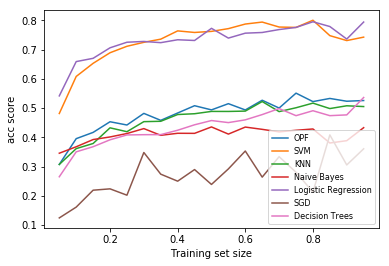

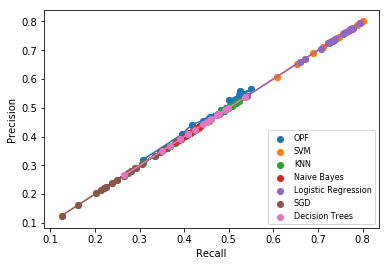

In [13]:
read_dataset()